In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [51]:
file_paths = {
    "NVIDIA": "../data/nvidia_stock_features_selected.csv",
    "Microsoft": "../data/microsoft_stock_features_selected.csv",
    "Apple": "../data/apple_stock_features_selected.csv",
}

# Select features for training
features = ["Close", "High", "Low", "Open", "Volume", "SMA_20", "EMA_20", "SMA_50", "EMA_50", "SMA_200", "EMA_200"]
target = "Close"

In [52]:
def load_and_preprocess_data(stock):
    """
    Loads stock data, normalizes it, and returns numpy arrays.
    """
    file_path = file_paths[stock]
    df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    
    # Normalize feature columns
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert to numpy
    data_np = df[features].values
    target_np = df[target].values

    return data_np, target_np

In [53]:
def create_edge_index(num_nodes):
    """
    Creates sequential edges between time steps.
    """
    edge_index = []
    for i in range(num_nodes - 1):  # Forward and backward connections
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])

    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [54]:
def create_graph_data(stock):
    """
    Converts stock data into PyTorch Geometric graph format.
    """
    data_np, target_np = load_and_preprocess_data(stock)
    num_nodes = len(data_np)

    # Create edge index
    edge_index = create_edge_index(num_nodes)

    # Convert to PyTorch tensors
    x = torch.tensor(data_np, dtype=torch.float)
    y = torch.tensor(target_np, dtype=torch.float).view(-1, 1)

    # Create graph data object
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    
    return graph_data

In [55]:
class TGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TGCN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.relu(self.gcn1(x, edge_index))
        x = self.relu(self.gcn2(x, edge_index))
        x = x.view(1, x.shape[0], x.shape[1])  # Reshape for LSTM
        x, _ = self.lstm(x)
        x = self.fc(x.squeeze(0))  # Fully connected layer
        return x

In [56]:
# Training parameters
input_dim = len(features)
hidden_dim = 64
output_dim = 1
num_epochs = 50
learning_rate = 0.001

# Function to train and evaluate the model
def train_tgnn(stock):
    """
    Trains and evaluates the T-GNN model for a given stock.
    Computes MSE and R² score for evaluation.
    """
    print(f"\n=== Training T-GNN for {stock} ===")

    # Load graph data
    graph_data = create_graph_data(stock)

    # Create separate edge indices for train and test
    train_size = int(0.8 * len(graph_data.x))
    train_data = Data(
        x=graph_data.x[:train_size], 
        edge_index=create_edge_index(train_size),  
        y=graph_data.y[:train_size]
    )
    test_data = Data(
        x=graph_data.x[train_size:], 
        edge_index=create_edge_index(len(graph_data.x) - train_size),  
        y=graph_data.y[train_size:]
    )

    # Initialize model, optimizer, and loss function
    model = TGCN(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(test_data).numpy().flatten()
        actuals = test_data.y.numpy().flatten()

    # Compute Evaluation Metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f"\nEvaluation for {stock}:")
    print(f"MSE: {mse:.6f}")
    print(f"R2 Score: {r2:.6f}")

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label="Actual", alpha=0.7)
    plt.plot(predictions, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title(f"Stock Price Prediction using T-GNN ({stock})")
    plt.show()

    # return {"Stock": stock, "MSE": mse, "R2": r2}


=== Training T-GNN for NVIDIA ===
Epoch 10/50, Loss: 0.000161
Epoch 20/50, Loss: 0.000084
Epoch 30/50, Loss: 0.000039
Epoch 40/50, Loss: 0.000012
Epoch 50/50, Loss: 0.000007

Evaluation for NVIDIA:
MSE: 0.009311
R2 Score: 0.872755


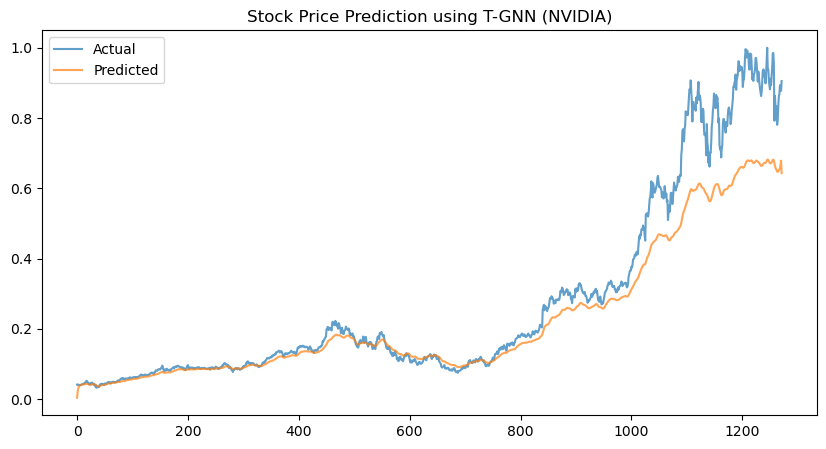

In [147]:
train_tgnn("NVIDIA")


=== Training T-GNN for Microsoft ===
Epoch 10/50, Loss: 0.001355
Epoch 20/50, Loss: 0.000621
Epoch 30/50, Loss: 0.000210
Epoch 40/50, Loss: 0.000034
Epoch 50/50, Loss: 0.000026

Evaluation for Microsoft:
MSE: 0.003901
R2 Score: 0.934400


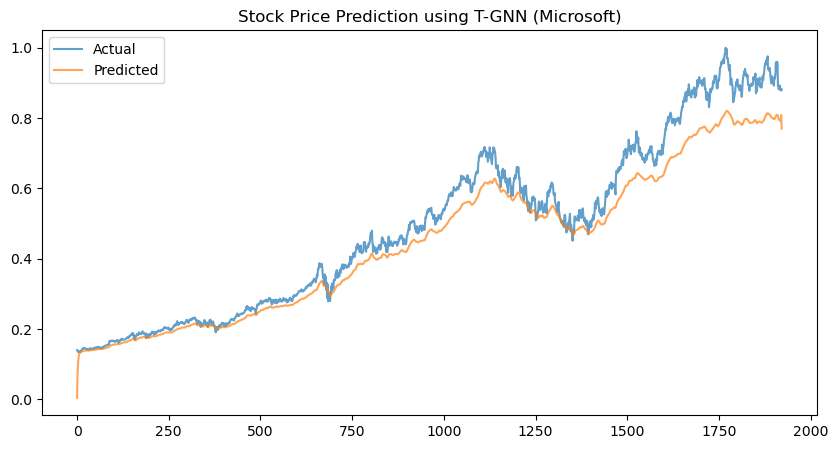

In [145]:
train_tgnn("Microsoft")


=== Training T-GNN for Apple ===


Epoch 10/50, Loss: 0.000752
Epoch 20/50, Loss: 0.000292
Epoch 30/50, Loss: 0.000075
Epoch 40/50, Loss: 0.000031
Epoch 50/50, Loss: 0.000007

Evaluation for Apple:
MSE: 0.000559
R2 Score: 0.991262


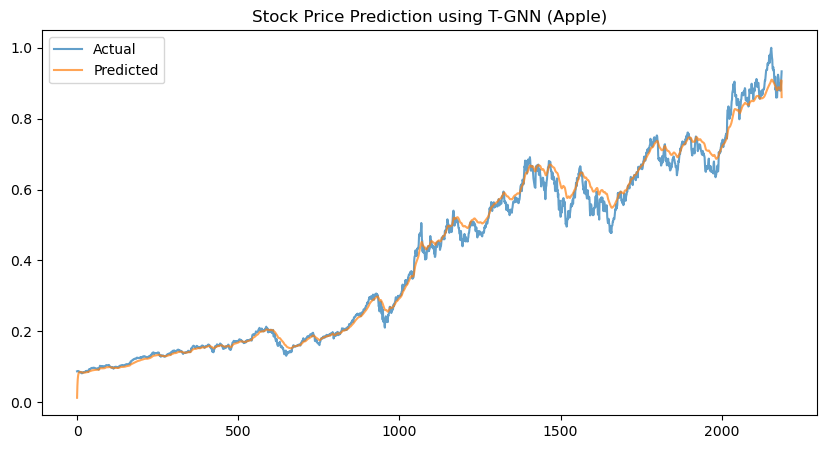

In [146]:
train_tgnn("Apple")

1. NVIDIA
- The model follows the trend well but lags behind during high-volatility jumps.
- This suggests that the model struggles to capture rapid momentum shifts.

2. Microsoft
- Huge improvement over previous runs.
- Has an MSE of 0.0039 and R² = 0.93, meaning it captures 93% of price variance.

3. Apple
- Best model performance with an R² of 0.99.
- Extremely close predictions with minimal deviation.

In [57]:
import optuna
import random

In [58]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [59]:
def objective(trial, stock):
    print(f"\nRunning optuna trial for {stock}")

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [32,64,128,256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    epochs = trial.suggest_int("epochs", 50, 100)

    set_seed(42)

    graph_data = create_graph_data(stock)

    train_size = int(0.8 * len(graph_data.x))
    train_data = Data(
        x=graph_data.x[:train_size],
        edge_index=create_edge_index(train_size),
        y=graph_data.y[:train_size]
    )
    test_data = Data(
        x=graph_data.x[train_size:],
        edge_index=create_edge_index(len(graph_data.x) - train_size),
        y=graph_data.y[train_size:]
    )

    class TGCN_Optimized(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(TGCN_Optimized, self).__init__()
            self.gcn1 = GCNConv(input_dim, hidden_dim)
            self.gcn2 = GCNConv(hidden_dim, hidden_dim)
            self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.dropout = nn.Dropout(p = dropout_rate)
            self.relu = nn.ReLU()

        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            x = self.relu(self.gcn1(x, edge_index))
            x = self.dropout(x)
            x = self.relu(self.gcn2(x, edge_index))
            x = x.view(1, x.shape[0], x.shape[1])
            x, _ = self.lstm(x)
            x = self.fc(x.squeeze(0))
            return x
    
    model = TGCN_Optimized(input_dim=len(features), hidden_dim=hidden_dim, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_data.y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(test_data).numpy().flatten()
        actuals = test_data.y.numpy().flatten()

    mse = mean_squared_error(actuals, predictions)
    return mse

In [60]:
def optimize_tgnn(stock, n_trials=25):
    print(f"\nRunning optuna for {stock} with {n_trials} trials.")

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, stock), n_trials=n_trials)

    best_params = study.best_params
    best_mse = study.best_value

    print(f"\nBest parameters for {stock}: {best_params}")
    print(f"\nBest MSE: {best_mse:.6f}")

    return best_params, best_mse

In [61]:
optuna_nvidia_params, optuna_nvidia_mse = optimize_tgnn("NVIDIA")

[I 2025-03-07 15:10:13,253] A new study created in memory with name: no-name-2d8b61d5-d7f8-4956-9d3d-2f36c31d228c



Running optuna for NVIDIA with 25 trials.

Running optuna trial for NVIDIA


[I 2025-03-07 15:10:15,930] Trial 0 finished with value: 0.05157623067498207 and parameters: {'learning_rate': 0.007420418512346328, 'hidden_dim': 32, 'dropout_rate': 0.4692341732229215, 'epochs': 86}. Best is trial 0 with value: 0.05157623067498207.



Running optuna trial for NVIDIA


[I 2025-03-07 15:10:19,390] Trial 1 finished with value: 0.050247155129909515 and parameters: {'learning_rate': 0.0003070375268474464, 'hidden_dim': 64, 'dropout_rate': 0.4040422493381265, 'epochs': 72}. Best is trial 1 with value: 0.050247155129909515.



Running optuna trial for NVIDIA


[I 2025-03-07 15:10:22,190] Trial 2 finished with value: 0.04989198222756386 and parameters: {'learning_rate': 0.0002547122770044546, 'hidden_dim': 32, 'dropout_rate': 0.15234090219240506, 'epochs': 91}. Best is trial 2 with value: 0.04989198222756386.



Running optuna trial for NVIDIA


[I 2025-03-07 15:10:37,066] Trial 3 finished with value: 0.08271945267915726 and parameters: {'learning_rate': 0.004001779413145583, 'hidden_dim': 256, 'dropout_rate': 0.2848223281185883, 'epochs': 55}. Best is trial 2 with value: 0.04989198222756386.



Running optuna trial for NVIDIA


[I 2025-03-07 15:10:38,888] Trial 4 finished with value: 0.04124690219759941 and parameters: {'learning_rate': 0.004550107068110374, 'hidden_dim': 32, 'dropout_rate': 0.14242918836704913, 'epochs': 56}. Best is trial 4 with value: 0.04124690219759941.



Running optuna trial for NVIDIA


[I 2025-03-07 15:10:53,508] Trial 5 finished with value: 0.0039278315380215645 and parameters: {'learning_rate': 0.0016851496002645472, 'hidden_dim': 256, 'dropout_rate': 0.1739111720626211, 'epochs': 56}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:11:04,078] Trial 6 finished with value: 0.01920805126428604 and parameters: {'learning_rate': 0.00042144501119795305, 'hidden_dim': 128, 'dropout_rate': 0.4605138726362007, 'epochs': 100}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:11:14,569] Trial 7 finished with value: 0.018735861405730247 and parameters: {'learning_rate': 0.0004249310745009152, 'hidden_dim': 128, 'dropout_rate': 0.4812448696924573, 'epochs': 100}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:11:21,895] Trial 8 finished with value: 0.017291422933340073 and parameters: {'learning_rate': 0.0014920606399088615, 'hidden_dim': 128, 'dropout_rate': 0.49167059585411155, 'epochs': 69}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:11:23,921] Trial 9 finished with value: 0.039232783019542694 and parameters: {'learning_rate': 0.0033971543795842736, 'hidden_dim': 32, 'dropout_rate': 0.26260771063808935, 'epochs': 64}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:11:37,253] Trial 10 finished with value: 0.04962927848100662 and parameters: {'learning_rate': 0.00010113815542645894, 'hidden_dim': 256, 'dropout_rate': 0.22228042792527505, 'epochs': 50}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:11:44,541] Trial 11 finished with value: 0.014315318316221237 and parameters: {'learning_rate': 0.0013399150552040257, 'hidden_dim': 128, 'dropout_rate': 0.37592789501566853, 'epochs': 68}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:12:00,802] Trial 12 finished with value: 0.006644848734140396 and parameters: {'learning_rate': 0.001143903833227652, 'hidden_dim': 256, 'dropout_rate': 0.3604878101686111, 'epochs': 62}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:12:16,901] Trial 13 finished with value: 0.0044660670682787895 and parameters: {'learning_rate': 0.0008677945424663037, 'hidden_dim': 256, 'dropout_rate': 0.3458541249951228, 'epochs': 61}. Best is trial 5 with value: 0.0039278315380215645.



Running optuna trial for NVIDIA


[I 2025-03-07 15:12:38,391] Trial 14 finished with value: 0.0028489830438047647 and parameters: {'learning_rate': 0.0007119239786792359, 'hidden_dim': 256, 'dropout_rate': 0.20460690606890214, 'epochs': 79}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:12:58,674] Trial 15 finished with value: 0.008550917729735374 and parameters: {'learning_rate': 0.0025289455904492614, 'hidden_dim': 256, 'dropout_rate': 0.193275432909273, 'epochs': 79}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:13:02,468] Trial 16 finished with value: 0.034278616309165955 and parameters: {'learning_rate': 0.0006821473619155362, 'hidden_dim': 64, 'dropout_rate': 0.10335677968483133, 'epochs': 77}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:13:24,100] Trial 17 finished with value: 0.005816987250000238 and parameters: {'learning_rate': 0.0023240472299798994, 'hidden_dim': 256, 'dropout_rate': 0.2230306626660662, 'epochs': 84}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:13:48,040] Trial 18 finished with value: 0.0032127450685948133 and parameters: {'learning_rate': 0.0001411737191605931, 'hidden_dim': 256, 'dropout_rate': 0.18214793842063975, 'epochs': 91}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:14:12,055] Trial 19 finished with value: 0.003452093806117773 and parameters: {'learning_rate': 0.0001106973401597105, 'hidden_dim': 256, 'dropout_rate': 0.10347596168551537, 'epochs': 92}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:14:16,031] Trial 20 finished with value: 0.04894527420401573 and parameters: {'learning_rate': 0.00017276085969711674, 'hidden_dim': 64, 'dropout_rate': 0.2553082259313173, 'epochs': 83}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:14:40,209] Trial 21 finished with value: 0.003821070771664381 and parameters: {'learning_rate': 0.00010157174294987256, 'hidden_dim': 256, 'dropout_rate': 0.10884617833468853, 'epochs': 93}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:15:03,528] Trial 22 finished with value: 0.003161779837682843 and parameters: {'learning_rate': 0.00015149130708576322, 'hidden_dim': 256, 'dropout_rate': 0.19612753651547954, 'epochs': 89}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:15:27,172] Trial 23 finished with value: 0.003015422960743308 and parameters: {'learning_rate': 0.00016895577245235329, 'hidden_dim': 256, 'dropout_rate': 0.2071089268362213, 'epochs': 88}. Best is trial 14 with value: 0.0028489830438047647.



Running optuna trial for NVIDIA


[I 2025-03-07 15:15:48,523] Trial 24 finished with value: 0.002918964484706521 and parameters: {'learning_rate': 0.00020139810461170188, 'hidden_dim': 256, 'dropout_rate': 0.3108576648293079, 'epochs': 81}. Best is trial 14 with value: 0.0028489830438047647.



Best parameters for NVIDIA: {'learning_rate': 0.0007119239786792359, 'hidden_dim': 256, 'dropout_rate': 0.20460690606890214, 'epochs': 79}

Best MSE: 0.002849


In [62]:
optuna_microsoft_params, optuna_microsoft_mse = optimize_tgnn("Microsoft")

[I 2025-03-07 15:15:48,538] A new study created in memory with name: no-name-b4b1d001-7607-4e4c-a2be-83b7fefa6cf8



Running optuna for Microsoft with 25 trials.

Running optuna trial for Microsoft


[I 2025-03-07 15:16:05,276] Trial 0 finished with value: 0.012614071369171143 and parameters: {'learning_rate': 0.0007184381966640689, 'hidden_dim': 128, 'dropout_rate': 0.16392115471805352, 'epochs': 99}. Best is trial 0 with value: 0.012614071369171143.



Running optuna trial for Microsoft


[I 2025-03-07 15:16:43,736] Trial 1 finished with value: 0.03827277198433876 and parameters: {'learning_rate': 0.006019660479007235, 'hidden_dim': 256, 'dropout_rate': 0.300361295048448, 'epochs': 97}. Best is trial 0 with value: 0.012614071369171143.



Running optuna trial for Microsoft


[I 2025-03-07 15:17:07,441] Trial 2 finished with value: 0.0046132891438901424 and parameters: {'learning_rate': 0.0008025416662705167, 'hidden_dim': 256, 'dropout_rate': 0.40105915853976215, 'epochs': 59}. Best is trial 2 with value: 0.0046132891438901424.



Running optuna trial for Microsoft


[I 2025-03-07 15:17:13,006] Trial 3 finished with value: 0.010135243646800518 and parameters: {'learning_rate': 0.0005395513309268819, 'hidden_dim': 64, 'dropout_rate': 0.1463056752855336, 'epochs': 73}. Best is trial 2 with value: 0.0046132891438901424.



Running optuna trial for Microsoft


[I 2025-03-07 15:17:38,455] Trial 4 finished with value: 0.006738795433193445 and parameters: {'learning_rate': 0.0008935831636945374, 'hidden_dim': 256, 'dropout_rate': 0.23973066697545373, 'epochs': 63}. Best is trial 2 with value: 0.0046132891438901424.



Running optuna trial for Microsoft


[I 2025-03-07 15:17:59,651] Trial 5 finished with value: 0.03760867193341255 and parameters: {'learning_rate': 0.00371687867059432, 'hidden_dim': 256, 'dropout_rate': 0.39624924807324013, 'epochs': 53}. Best is trial 2 with value: 0.0046132891438901424.



Running optuna trial for Microsoft


[I 2025-03-07 15:18:06,163] Trial 6 finished with value: 0.0018520571757107973 and parameters: {'learning_rate': 0.0006963243849890526, 'hidden_dim': 64, 'dropout_rate': 0.404574746813982, 'epochs': 84}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:18:10,174] Trial 7 finished with value: 0.048685867339372635 and parameters: {'learning_rate': 0.0003812132681318544, 'hidden_dim': 32, 'dropout_rate': 0.15285955171629195, 'epochs': 85}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:18:33,130] Trial 8 finished with value: 0.02634221501648426 and parameters: {'learning_rate': 0.006695852736401273, 'hidden_dim': 256, 'dropout_rate': 0.20560914684838277, 'epochs': 57}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:09,587] Trial 9 finished with value: 0.006177570670843124 and parameters: {'learning_rate': 0.0010521443945631203, 'hidden_dim': 256, 'dropout_rate': 0.1361303310686339, 'epochs': 91}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:15,387] Trial 10 finished with value: 0.040889739990234375 and parameters: {'learning_rate': 0.0001557478991578206, 'hidden_dim': 64, 'dropout_rate': 0.489610816192797, 'epochs': 77}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:20,995] Trial 11 finished with value: 0.007962874136865139 and parameters: {'learning_rate': 0.0017996255985956201, 'hidden_dim': 64, 'dropout_rate': 0.38549064956624446, 'epochs': 71}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:24,831] Trial 12 finished with value: 0.10058591514825821 and parameters: {'learning_rate': 0.00025407474801466564, 'hidden_dim': 32, 'dropout_rate': 0.43145197797861473, 'epochs': 83}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:35,442] Trial 13 finished with value: 0.016658026725053787 and parameters: {'learning_rate': 0.0017851752616305809, 'hidden_dim': 128, 'dropout_rate': 0.32388154267080566, 'epochs': 64}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:40,536] Trial 14 finished with value: 0.007486065849661827 and parameters: {'learning_rate': 0.0018964349737669436, 'hidden_dim': 64, 'dropout_rate': 0.49981954399784057, 'epochs': 66}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:46,726] Trial 15 finished with value: 0.061111386865377426 and parameters: {'learning_rate': 0.0001177262094985793, 'hidden_dim': 64, 'dropout_rate': 0.35079282444701404, 'epochs': 82}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:55,619] Trial 16 finished with value: 0.03903573378920555 and parameters: {'learning_rate': 0.00030770559815045085, 'hidden_dim': 128, 'dropout_rate': 0.43224385969529683, 'epochs': 52}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:19:59,899] Trial 17 finished with value: 0.02220713160932064 and parameters: {'learning_rate': 0.001260204107861891, 'hidden_dim': 32, 'dropout_rate': 0.27030046752399867, 'epochs': 90}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:20:31,172] Trial 18 finished with value: 0.0034242926631122828 and parameters: {'learning_rate': 0.0005004371269149487, 'hidden_dim': 256, 'dropout_rate': 0.4419382819402369, 'epochs': 77}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:20:36,756] Trial 19 finished with value: 0.045730508863925934 and parameters: {'learning_rate': 0.00019191541803557805, 'hidden_dim': 64, 'dropout_rate': 0.3543591248446972, 'epochs': 77}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:21:11,407] Trial 20 finished with value: 0.0035909581929445267 and parameters: {'learning_rate': 0.0004705896440945689, 'hidden_dim': 256, 'dropout_rate': 0.45171709613891187, 'epochs': 89}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:21:47,014] Trial 21 finished with value: 0.0027381684631109238 and parameters: {'learning_rate': 0.00041697618656815573, 'hidden_dim': 256, 'dropout_rate': 0.4610068939318871, 'epochs': 90}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:22:24,437] Trial 22 finished with value: 0.004011017270386219 and parameters: {'learning_rate': 0.0005444697074359268, 'hidden_dim': 256, 'dropout_rate': 0.4639343196818291, 'epochs': 95}. Best is trial 6 with value: 0.0018520571757107973.



Running optuna trial for Microsoft


[I 2025-03-07 15:22:56,213] Trial 23 finished with value: 0.0014880597591400146 and parameters: {'learning_rate': 0.0002818947425165631, 'hidden_dim': 256, 'dropout_rate': 0.41515911376974624, 'epochs': 81}. Best is trial 23 with value: 0.0014880597591400146.



Running optuna trial for Microsoft


[I 2025-03-07 15:23:30,124] Trial 24 finished with value: 0.0011313516879454255 and parameters: {'learning_rate': 0.0002410172296672955, 'hidden_dim': 256, 'dropout_rate': 0.3626449462027742, 'epochs': 86}. Best is trial 24 with value: 0.0011313516879454255.



Best parameters for Microsoft: {'learning_rate': 0.0002410172296672955, 'hidden_dim': 256, 'dropout_rate': 0.3626449462027742, 'epochs': 86}

Best MSE: 0.001131


In [63]:
optuna_apple_params, optuna_apple_mse = optimize_tgnn("Apple")

[I 2025-03-07 15:23:30,135] A new study created in memory with name: no-name-436aaede-d517-463d-bf0e-9e6c8d89a1ff



Running optuna for Apple with 25 trials.

Running optuna trial for Apple


[I 2025-03-07 15:23:35,133] Trial 0 finished with value: 0.0717395767569542 and parameters: {'learning_rate': 0.00014424406860616082, 'hidden_dim': 32, 'dropout_rate': 0.14689782454160585, 'epochs': 98}. Best is trial 0 with value: 0.0717395767569542.



Running optuna trial for Apple


[I 2025-03-07 15:23:40,371] Trial 1 finished with value: 0.048919353634119034 and parameters: {'learning_rate': 0.00016846667195903633, 'hidden_dim': 64, 'dropout_rate': 0.21821817059811638, 'epochs': 60}. Best is trial 1 with value: 0.048919353634119034.



Running optuna trial for Apple


[I 2025-03-07 15:23:53,460] Trial 2 finished with value: 0.031074894592165947 and parameters: {'learning_rate': 0.0025888257567492023, 'hidden_dim': 128, 'dropout_rate': 0.36540039001750935, 'epochs': 73}. Best is trial 2 with value: 0.031074894592165947.



Running optuna trial for Apple


[I 2025-03-07 15:23:57,829] Trial 3 finished with value: 0.027234667912125587 and parameters: {'learning_rate': 0.0004757661576442017, 'hidden_dim': 32, 'dropout_rate': 0.3229873960543309, 'epochs': 89}. Best is trial 3 with value: 0.027234667912125587.



Running optuna trial for Apple


[I 2025-03-07 15:24:01,501] Trial 4 finished with value: 0.02741687372326851 and parameters: {'learning_rate': 0.0012383431285122699, 'hidden_dim': 32, 'dropout_rate': 0.284630418127287, 'epochs': 74}. Best is trial 3 with value: 0.027234667912125587.



Running optuna trial for Apple


[I 2025-03-07 15:24:16,130] Trial 5 finished with value: 0.015115346759557724 and parameters: {'learning_rate': 0.0003045206389616684, 'hidden_dim': 128, 'dropout_rate': 0.3306321578524201, 'epochs': 80}. Best is trial 5 with value: 0.015115346759557724.



Running optuna trial for Apple


[I 2025-03-07 15:24:21,611] Trial 6 finished with value: 0.03445284441113472 and parameters: {'learning_rate': 0.0068332628101599934, 'hidden_dim': 64, 'dropout_rate': 0.10994059504594081, 'epochs': 59}. Best is trial 5 with value: 0.015115346759557724.



Running optuna trial for Apple


[I 2025-03-07 15:24:38,688] Trial 7 finished with value: 0.15642942488193512 and parameters: {'learning_rate': 0.009700522087046411, 'hidden_dim': 128, 'dropout_rate': 0.32895143768845736, 'epochs': 96}. Best is trial 5 with value: 0.015115346759557724.



Running optuna trial for Apple


[I 2025-03-07 15:24:50,301] Trial 8 finished with value: 0.026513580232858658 and parameters: {'learning_rate': 0.00271486946998568, 'hidden_dim': 128, 'dropout_rate': 0.2877711615643753, 'epochs': 64}. Best is trial 5 with value: 0.015115346759557724.



Running optuna trial for Apple


[I 2025-03-07 15:25:03,340] Trial 9 finished with value: 0.00787348486483097 and parameters: {'learning_rate': 0.0007952710642258126, 'hidden_dim': 128, 'dropout_rate': 0.3032452373720147, 'epochs': 71}. Best is trial 9 with value: 0.00787348486483097.



Running optuna trial for Apple


[I 2025-03-07 15:25:42,313] Trial 10 finished with value: 0.004566455725580454 and parameters: {'learning_rate': 0.0007533177730037281, 'hidden_dim': 256, 'dropout_rate': 0.47613850471441627, 'epochs': 83}. Best is trial 10 with value: 0.004566455725580454.



Running optuna trial for Apple


[I 2025-03-07 15:26:19,642] Trial 11 finished with value: 0.006227507255971432 and parameters: {'learning_rate': 0.0009623523707176592, 'hidden_dim': 256, 'dropout_rate': 0.4753063259052103, 'epochs': 83}. Best is trial 10 with value: 0.004566455725580454.



Running optuna trial for Apple


[I 2025-03-07 15:26:57,705] Trial 12 finished with value: 0.010622146539390087 and parameters: {'learning_rate': 0.0011950658486949276, 'hidden_dim': 256, 'dropout_rate': 0.4813305445613301, 'epochs': 85}. Best is trial 10 with value: 0.004566455725580454.



Running optuna trial for Apple


[I 2025-03-07 15:27:20,340] Trial 13 finished with value: 0.00048078186227940023 and parameters: {'learning_rate': 0.00041961326277488583, 'hidden_dim': 256, 'dropout_rate': 0.4820209775341852, 'epochs': 50}. Best is trial 13 with value: 0.00048078186227940023.



Running optuna trial for Apple


[I 2025-03-07 15:27:42,769] Trial 14 finished with value: 0.0021134621929377317 and parameters: {'learning_rate': 0.0003384004971346441, 'hidden_dim': 256, 'dropout_rate': 0.4167142506631169, 'epochs': 50}. Best is trial 13 with value: 0.00048078186227940023.



Running optuna trial for Apple


[I 2025-03-07 15:28:05,306] Trial 15 finished with value: 0.0011397162452340126 and parameters: {'learning_rate': 0.00027474990685728905, 'hidden_dim': 256, 'dropout_rate': 0.4083699224801662, 'epochs': 50}. Best is trial 13 with value: 0.00048078186227940023.



Running optuna trial for Apple


[I 2025-03-07 15:28:28,706] Trial 16 finished with value: 0.0020897346548736095 and parameters: {'learning_rate': 0.00010536571264306924, 'hidden_dim': 256, 'dropout_rate': 0.41615821951083815, 'epochs': 52}. Best is trial 13 with value: 0.00048078186227940023.



Running optuna trial for Apple


[I 2025-03-07 15:28:53,384] Trial 17 finished with value: 0.0010810231324285269 and parameters: {'learning_rate': 0.000237776869316136, 'hidden_dim': 256, 'dropout_rate': 0.42351468760362637, 'epochs': 55}. Best is trial 13 with value: 0.00048078186227940023.



Running optuna trial for Apple


[I 2025-03-07 15:29:22,827] Trial 18 finished with value: 0.0013138029025867581 and parameters: {'learning_rate': 0.00046360422116345463, 'hidden_dim': 256, 'dropout_rate': 0.44244337613736606, 'epochs': 66}. Best is trial 13 with value: 0.00048078186227940023.



Running optuna trial for Apple


[I 2025-03-07 15:29:49,134] Trial 19 finished with value: 0.00034785259049385786 and parameters: {'learning_rate': 0.00019679434232201812, 'hidden_dim': 256, 'dropout_rate': 0.37319245320223904, 'epochs': 58}. Best is trial 19 with value: 0.00034785259049385786.



Running optuna trial for Apple


[I 2025-03-07 15:29:53,877] Trial 20 finished with value: 0.1619998663663864 and parameters: {'learning_rate': 0.0001012354014940139, 'hidden_dim': 64, 'dropout_rate': 0.37372737519953175, 'epochs': 57}. Best is trial 19 with value: 0.00034785259049385786.



Running optuna trial for Apple


[I 2025-03-07 15:30:18,411] Trial 21 finished with value: 0.00029144433210603893 and parameters: {'learning_rate': 0.00020672569134891399, 'hidden_dim': 256, 'dropout_rate': 0.3753368688243504, 'epochs': 55}. Best is trial 21 with value: 0.00029144433210603893.



Running optuna trial for Apple


[I 2025-03-07 15:30:47,974] Trial 22 finished with value: 0.0007963994867168367 and parameters: {'learning_rate': 0.00018551998067954672, 'hidden_dim': 256, 'dropout_rate': 0.23721345882038997, 'epochs': 64}. Best is trial 21 with value: 0.00029144433210603893.



Running optuna trial for Apple


[I 2025-03-07 15:31:12,525] Trial 23 finished with value: 0.00041989286546595395 and parameters: {'learning_rate': 0.0004733348337274531, 'hidden_dim': 256, 'dropout_rate': 0.374243505985163, 'epochs': 55}. Best is trial 21 with value: 0.00029144433210603893.



Running optuna trial for Apple


[I 2025-03-07 15:31:43,050] Trial 24 finished with value: 0.001852069515734911 and parameters: {'learning_rate': 0.0006048754103681802, 'hidden_dim': 256, 'dropout_rate': 0.3615214612112316, 'epochs': 67}. Best is trial 21 with value: 0.00029144433210603893.



Best parameters for Apple: {'learning_rate': 0.00020672569134891399, 'hidden_dim': 256, 'dropout_rate': 0.3753368688243504, 'epochs': 55}

Best MSE: 0.000291


In [69]:
def train_final_tgnn(stock, best_params):
    print(f"\nTraining optimized T-GNN for {stock}")

    graph_data = create_graph_data(stock)

    train_size = int(0.8 * len(graph_data.x))
    train_data = Data(
        x=graph_data.x[:train_size],
        edge_index=create_edge_index(train_size),
        y=graph_data.y[:train_size]
    )
    test_data = Data(
        x=graph_data.x[train_size:],
        edge_index=create_edge_index(len(graph_data.x) - train_size),
        y=graph_data.y[train_size:]
    )

    learning_rate = best_params["learning_rate"]
    hidden_dim = best_params["hidden_dim"]
    dropout_rate = best_params["dropout_rate"]
    epochs = best_params["epochs"]

    class TGCN_Final(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(TGCN_Final, self).__init__()
            self.gcn1 = GCNConv(input_dim, hidden_dim)
            self.gcn2 = GCNConv(hidden_dim, hidden_dim)
            self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.dropout = nn.Dropout(p=dropout_rate)
            self.relu = nn.ReLU()

        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            x = self.relu(self.gcn1(x, edge_index))
            x = self.dropout(x)
            x = self.relu(self.gcn2(x, edge_index))
            x = x.view(1, x.shape[0], x.shape[1])  # Reshape for LSTM
            x, _ = self.lstm(x)
            x = self.fc(x.squeeze(0))  # Fully connected layer
            return x
        
    model = TGCN_Final(input_dim=len(features), hidden_dim=hidden_dim, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_data.y)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    model.eval()
    with torch.no_grad():
        predictions = model(test_data).numpy().flatten()
        actuals = test_data.y.numpy().flatten()
    
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f"\nFinal Evaluation for {stock}:")
    print(f"MSE: {mse:.6f}")
    print(f"R2 Score: {r2:.6f}")

    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label="Actual", alpha=0.7)
    plt.plot(predictions, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title(f"Final Stock Price Prediction using Optimized T-GNN ({stock})")
    plt.show()

    return {"Stock": stock, "MSE": mse, "R2": r2}


Training optimized T-GNN for NVIDIA
Epoch 10/79, Loss: 0.000109
Epoch 20/79, Loss: 0.000071
Epoch 30/79, Loss: 0.000034
Epoch 40/79, Loss: 0.000019
Epoch 50/79, Loss: 0.000008
Epoch 60/79, Loss: 0.000003
Epoch 70/79, Loss: 0.000003

Final Evaluation for NVIDIA:
MSE: 0.002609
R2 Score: 0.964344


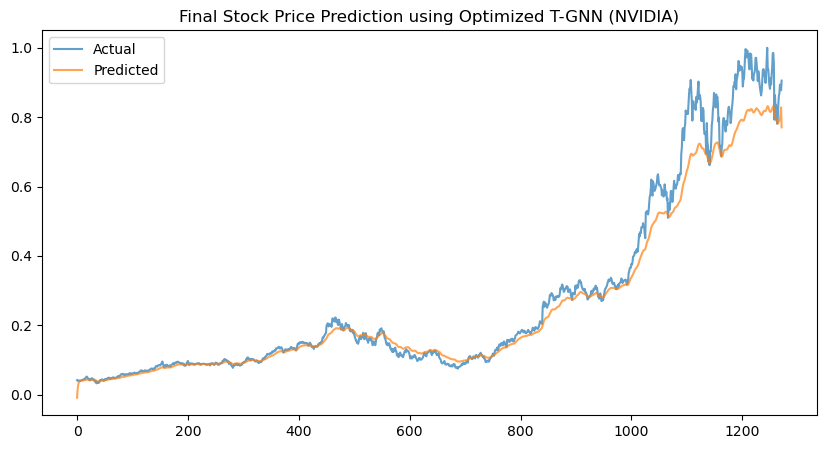

In [70]:
optimized_nvidia_results = train_final_tgnn("NVIDIA", optuna_nvidia_params)


Training optimized T-GNN for Microsoft
Epoch 10/86, Loss: 0.000561
Epoch 20/86, Loss: 0.000529
Epoch 30/86, Loss: 0.000382
Epoch 40/86, Loss: 0.000087
Epoch 50/86, Loss: 0.000018
Epoch 60/86, Loss: 0.000015
Epoch 70/86, Loss: 0.000013
Epoch 80/86, Loss: 0.000009

Final Evaluation for Microsoft:
MSE: 0.000433
R2 Score: 0.992716


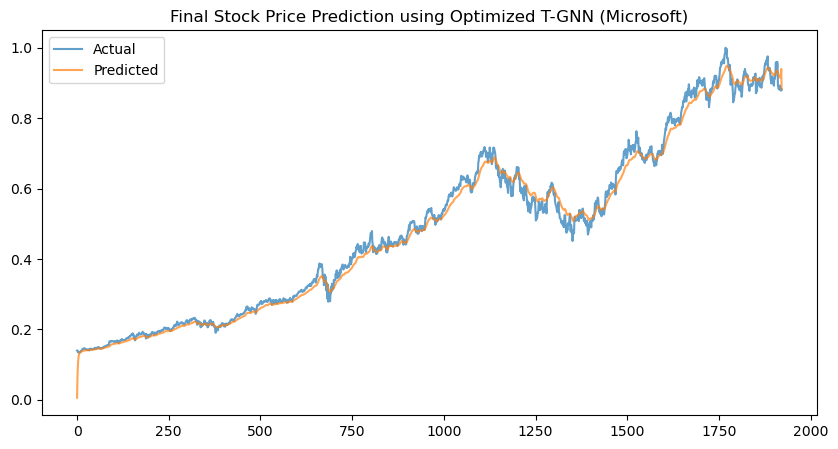

In [71]:
optimized_microsoft_results = train_final_tgnn("Microsoft", optuna_microsoft_params)


Training optimized T-GNN for Apple
Epoch 10/55, Loss: 0.000750
Epoch 20/55, Loss: 0.000207
Epoch 30/55, Loss: 0.000013
Epoch 40/55, Loss: 0.000020
Epoch 50/55, Loss: 0.000009

Final Evaluation for Apple:
MSE: 0.000677
R2 Score: 0.989416


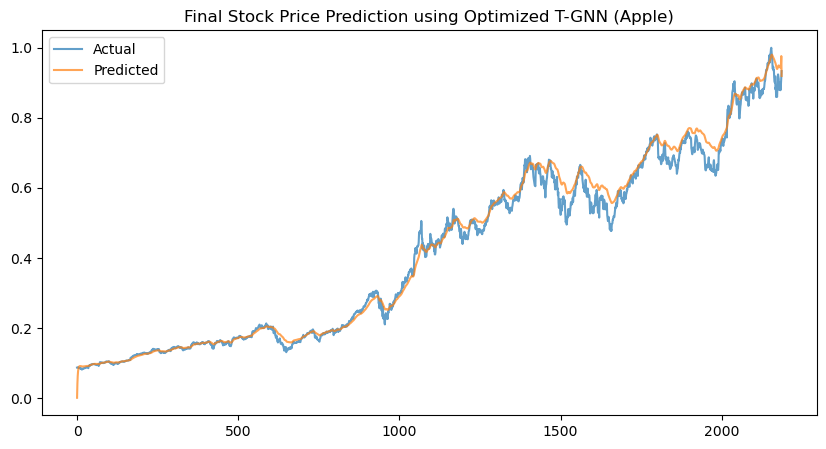

In [72]:
optimized_apple_results = train_final_tgnn("Apple", optuna_apple_params)

In [74]:
final_results = [
    {"Stock": "NVIDIA", "Baseline MSE": 0.0093, "Optimized MSE": optimized_nvidia_results["MSE"], 
     "Baseline R2": 0.8727, "Optimized R2": optimized_nvidia_results["R2"]},

    {"Stock": "Microsoft", "Baseline MSE": 0.0039, "Optimized MSE": optimized_microsoft_results["MSE"], 
     "Baseline R2": 0.9344, "Optimized R2": optimized_microsoft_results["R2"]},

    {"Stock": "Apple", "Baseline MSE": 0.000559, "Optimized MSE": optimized_apple_results["MSE"], 
     "Baseline R2": 0.9913, "Optimized R2": optimized_apple_results["R2"]}
]

df_final_results = pd.DataFrame(final_results)
df_final_results

,Stock,Baseline MSE,Optimized MSE,Baseline R2,Optimized R2
0,NVIDIA,0.009300,0.002609,0.8727,0.964344
1,Microsoft,0.003900,0.000433,0.9344,0.992716
2,Apple,0.000559,0.000677,0.9913,0.989416


1. Improvements
- NVIDIA: MSE dropped by 72%, and R2 improved from 0.87 → 0.96.
- Microsoft: MSE dropped by 89%, and R2 jumped from 0.93 → 0.99 (Best Performance).

2. Exceptions
- MSE increased slightly (0.00056 → 0.00068).
- R2 dropped slightly (0.9913 → 0.9894).
- Apple was already near perfect, and Optuna may have slightly overfitted.